In [2]:

import os
import glob
import gc
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torchvision.transforms.v2 as v2
import torch.nn.functional as F

from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import EarlyStopping, ModelCheckpoint, TerminateOnNan
from ignite.contrib.handlers import ProgressBar
from ignite.metrics import Loss, Accuracy, Precision, Recall

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, 
                             precision_score, recall_score, f1_score, roc_curve, auc)

In [3]:
torch.manual_seed(42)
record_path=r"C:\Users\piotr\.cache\kagglehub\datasets\nih-chest-xrays\data\versions\3"

In [4]:
df_train=pd.read_parquet(r"Cleaned Data Files\df_train_cleaned.parquet")

In [5]:
image_paths=glob.glob(record_path+r"\**\*.png",recursive=True)

In [6]:
image_path_dict = {path.split("\\")[-1]: path for path in image_paths}

class XrayDataset(Dataset):
    def __init__(self, df, image_path_dict, transform=None):
        self.df = df
        self.image_path_dict = image_path_dict  # Dictionary for quick lookup
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df.iloc[idx]['Image Index']
        image_path = self.image_path_dict[image_name]
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.df.iloc[idx].iloc[1:].values.astype(float)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label)

#Data Augmentation transform
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((224, 224)),
    v2.RandomAffine(degrees=5, translate=(0.02, 0.02), scale=(0.95, 1.05), shear=5),
    v2.RandomHorizontalFlip(p=0.5),
    # v2.ColorJitter(brightness=0.1, contrast=0.1),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [7]:

# Split the training dataset into train and validation sets (80% train, 20% validation)
train_df, val_df = train_test_split(df_train, test_size=0.2, random_state=42)
# Create new datasets for training and validation
train_dataset = XrayDataset(train_df, image_path_dict, transform=transform)
val_dataset = XrayDataset(val_df, image_path_dict, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False,pin_memory=True)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Count how many classes remain after dropping rare diseases
num_classes = 8
print("Number of classes:", num_classes)
class LSEPoolingHead(nn.Module):
    """
    Custom head to incorporate LSE pooling between 
    the final feature map and the output layer.
    """
    def __init__(self, in_features, num_classes, r=10.0):
        super().__init__()
        self.r = r
        self.classifier = nn.Linear(in_features, num_classes)

    def forward(self, x):
        # Expecting x shape = (batch, C, H, W)
        # 1) LSE pooling
        b, c, h, w = x.shape
        x_2d = x.view(b, c, -1)  # shape: (batch, C, H*W)

        # For numerical stability, subtract the max along the spatial dim
        x_max, _ = x_2d.max(dim=2, keepdim=True)  # shape: (batch, C, 1)
        x_stable = x_2d - x_max

        # LSE formula
        out = (1.0 / self.r) * torch.log(
            1e-6 + torch.mean(torch.exp(self.r * x_stable), dim=2)
        ) + x_max.squeeze(2)  # shape: (batch, C)

        # 2) Final linear layer to get (batch, num_classes)
        logits = self.classifier(out)
        return logits

class DenseNetWithLSE(nn.Module):
    """
    Wraps a DenseNet-121, but removes its adaptive avg pool and 
    built-in classifier. Instead, we apply ReLU + LSEPoolingHead.
    """
    def __init__(self, num_classes=8, r=10.0, freeze_until='denseblock4'):
        super().__init__()
        # Load the pretrained DenseNet
        base_net = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

        # Freeze some parts if desired
        for name, param in base_net.features.named_parameters():
            # Example: freeze all layers except the last denseblock
            if freeze_until in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        # We'll keep the feature extractor, but skip the classifier
        self.features = base_net.features
        # We'll remove the built-in classifier to do custom pooling
        # Original: out = F.adaptive_avg_pool2d(out, (1, 1))
        # We'll override the forward to skip that

        # Build custom LSE head
        # DenseNet-121 final channels = 1024
        self.lse_head = LSEPoolingHead(
            in_features=1024, 
            num_classes=num_classes, 
            r=r
        )

    def forward(self, x):
        # 1) Pass input through the DenseNet feature layers
        out = self.features(x)                     # shape: (batch, 1024, H, W)
        out = F.relu(out, inplace=True)            # shape: (batch, 1024, H, W)
        # 2) Instead of adaptive pooling, do LSE pooling
        logits = self.lse_head(out)
        return logits
    
# We start with DenseNet121
model = DenseNetWithLSE(
    num_classes=num_classes, 
    r=10.0,                 # hyperparameter for LSE
    freeze_until='denseblock4'  # or adjust as you want
)
model = model.to(device)

# Loss function and optimizer
pos_weight = (df_train.iloc[:,1:]==0.).sum()/df_train.iloc[:,1:].sum()
class_weights=torch.tensor(pos_weight.values,dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                       lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)
# Create the trainer and evaluators
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)

val_metrics = {
    "accuracy": Accuracy(output_transform=lambda x: (torch.sigmoid(x[0]) > 0.5, x[1]), is_multilabel=True),
    "precision": Precision(average=False, output_transform=lambda x: (torch.sigmoid(x[0]) > 0.5, x[1]), is_multilabel=True),
    "recall": Recall(average=False, output_transform=lambda x: (torch.sigmoid(x[0]) > 0.5, x[1]), is_multilabel=True),
    "loss": Loss(criterion)
}

train_evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)

# Attach progress bar to the trainer
pbar = ProgressBar(persist=True)
pbar.attach(trainer, output_transform=lambda x: {"loss": x})

# Validation after each epoch
@trainer.on(Events.EPOCH_COMPLETED)
def run_validation(engine):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_loss = metrics['loss']
    print(f"\nValidation - Epoch: {engine.state.epoch} | "
          f"Avg accuracy: {avg_accuracy:.4f} | Avg loss: {avg_loss:.4f}")
@trainer.on(Events.EPOCH_COMPLETED)
def log_learning_rate(engine):
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Learning Rate after Epoch {engine.state.epoch}: {current_lr:.6f}")
@trainer.on(Events.EPOCH_COMPLETED)
def run_scheduler(engine):
    val_loss = val_evaluator.state.metrics["loss"]
    scheduler.step(val_loss)
    print(f"Scheduler stepped with validation loss: {val_loss:.4f}")
    
early_stopping = EarlyStopping(
    patience=5,  # Number of epochs to wait without improvement
    score_function=lambda engine: -engine.state.metrics["loss"],  # Use validation loss (negative for minimizing)
    trainer=trainer
)
val_evaluator.add_event_handler(Events.COMPLETED, early_stopping)
trainer.add_event_handler(Events.ITERATION_COMPLETED, TerminateOnNan())

checkpoint_handler = ModelCheckpoint(
    dirname='checkpoints',
    filename_prefix='chestxray',
    n_saved=1,
    create_dir=True,
    require_empty=False,
    score_function=lambda e: -e.state.metrics["loss"], 
    score_name="val_loss",
    global_step_transform=lambda e, _: e.state.epoch
)

val_evaluator.add_event_handler(Events.COMPLETED, checkpoint_handler, {
    'best_model': model
})

Using device: cuda
Number of classes: 8


c:\Users\piotr\anaconda3\Lib\site-packages\ignite\handlers\tqdm_logger.py:127: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [9]:
# trainer.run(train_loader, max_epochs=20)

In [10]:
#This is the model after training 20 epochs.
model.load_state_dict(torch.load(r"Checkpoint, our model trained for 20 epochs.pt"))

<All keys matched successfully>

In [11]:
df_test=pd.read_parquet(r"Cleaned Data Files\df_test_cleaned.parquet")

In [12]:
test_dataset = XrayDataset(df_test, image_path_dict, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)
logits = []
labels_list = []

def evaluate_step(engine, batch):
    model.eval()
    with torch.no_grad():
        images, label = batch
        images = images.to(device)
        label  = label.to(device)
        outputs = model(images)

        # Store predictions & labels
        logits.append(outputs.cpu().numpy())
        labels_list.append(label.cpu().numpy())

    return outputs, label

evaluator = Engine(evaluate_step)
evaluator.run(test_loader)

State:
	iteration: 682
	epoch: 1
	epoch_length: 682
	max_epochs: 1
	output: <class 'tuple'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [13]:
# Convert lists to arrays
logits_array = np.concatenate(logits, axis=0)
labels_array = np.concatenate(labels_list, axis=0)


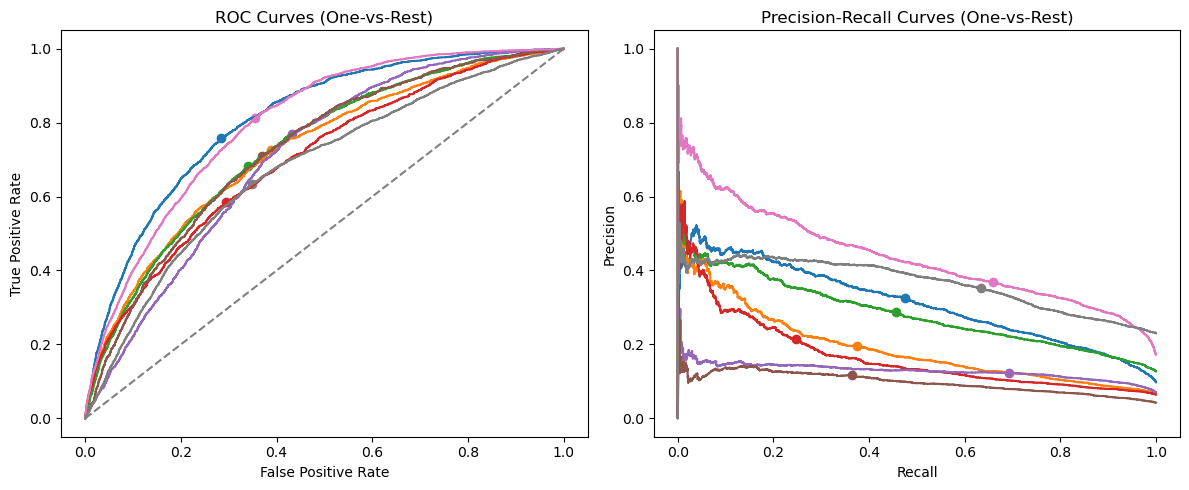

In [27]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc, f1_score

# Convert logits to probabilities (assuming multiclass classification)
probs = torch.sigmoid(torch.tensor(logits_array)).numpy()  # Shape: (num_samples, num_classes)

num_classes = probs.shape[1]
optimal_thresholds_roc = np.zeros(num_classes)
optimal_thresholds_pr = np.zeros(num_classes)

plt.figure(figsize=(12, 5))

# Iterate over each class (One-vs-Rest approach)
for class_idx in range(num_classes):
    class_labels = labels_array[:, class_idx]  # Convert to binary labels (one vs rest)
    # Compute ROC Curve for the current class
    fpr, tpr, roc_thresholds = roc_curve(class_labels, probs[:, class_idx])
    roc_auc = auc(fpr, tpr)

    # Compute Youden’s J statistic for optimal ROC-based threshold
    youden_j = tpr - fpr
    optimal_idx_roc = np.argmax(youden_j)
    optimal_thresholds_roc[class_idx] = roc_thresholds[optimal_idx_roc]

    # Compute Precision-Recall Curve for the current class
    precision, recall, pr_thresholds = precision_recall_curve(class_labels, probs[:, class_idx])
    pr_auc = auc(recall, precision)
    
    # Compute F1-score for each threshold
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)  # Avoid division by zero
    optimal_idx_pr = np.argmax(f1_scores)
    optimal_thresholds_pr[class_idx] = pr_thresholds[optimal_idx_pr]

    # Plot ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'Class {class_idx} (AUC = {roc_auc:.2f})')
    plt.scatter(fpr[optimal_idx_roc], tpr[optimal_idx_roc], label=f'Class {class_idx} Thresh = {optimal_thresholds_roc[class_idx]:.3f}')

    # Plot PR Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'Class {class_idx} (AUC = {pr_auc:.2f})')
    plt.scatter(recall[optimal_idx_pr], precision[optimal_idx_pr], label=f'Class {class_idx} Thresh = {optimal_thresholds_pr[class_idx]:.3f}')

# Format ROC plot
plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')

# Format PR plot
plt.subplot(1, 2, 2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves (One-vs-Rest)')

plt.tight_layout()
plt.show()


In [31]:
preds = (probs > optimal_thresholds_roc).astype(int)
y_true = labels_array.astype(int)
y_pred = preds.astype(int)

print("\nClassification Report (Per-Class):")
print(
    classification_report(
        y_true, y_pred, 
        target_names=[df_test.columns.tolist()[1:][i] for i in range(y_true.shape[1])]
    )
)



Classification Report (Per-Class):
                    precision    recall  f1-score   support

      Pneumothorax       0.22      0.76      0.35      2124
              Mass       0.12      0.73      0.21      1491
       Atelectasis       0.23      0.68      0.34      2764
            Nodule       0.12      0.58      0.20      1401
     Consolidation       0.12      0.77      0.20      1528
Pleural_Thickening       0.08      0.71      0.14       926
          Effusion       0.32      0.81      0.46      3755
      Infiltration       0.35      0.63      0.45      5013

         micro avg       0.20      0.71      0.31     19002
         macro avg       0.20      0.71      0.29     19002
      weighted avg       0.25      0.71      0.35     19002
       samples avg       0.16      0.38      0.21     19002



c:\Users\piotr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\piotr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\piotr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [32]:
preds = (probs > optimal_thresholds_pr).astype(int)
y_true = labels_array.astype(int)
y_pred = preds.astype(int)

print("\nClassification Report (Per-Class):")
print(
    classification_report(
        y_true, y_pred, 
        target_names=[df_test.columns.tolist()[1:][i] for i in range(y_true.shape[1])]
    )
)


Classification Report (Per-Class):
                    precision    recall  f1-score   support

      Pneumothorax       0.33      0.47      0.39      2124
              Mass       0.20      0.37      0.26      1491
       Atelectasis       0.29      0.46      0.35      2764
            Nodule       0.22      0.25      0.23      1401
     Consolidation       0.12      0.69      0.21      1528
Pleural_Thickening       0.12      0.36      0.18       926
          Effusion       0.37      0.66      0.47      3755
      Infiltration       0.35      0.63      0.45      5013

         micro avg       0.26      0.54      0.35     19002
         macro avg       0.25      0.49      0.32     19002
      weighted avg       0.29      0.54      0.37     19002
       samples avg       0.18      0.29      0.20     19002



c:\Users\piotr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\piotr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\piotr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
